# CPSC 330 Lecture 3

### Lecture outline

- Wave hello
- **Turn on recording**
- Overfitting revisited (5 min)
- Terminology: the 4 data sets (5 min)
- Sources of error and the "fundamental trade-off" (25 min)
- Break (5 min)
- True/False (10 min)
- Cross-validation (20 min)
- True/False (10 min)
- Overfitting on the (cross-)validation set (15 min)


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

from plot_classifier import plot_classifier

Load the data from last class, do the same preprocessing:

In [6]:
df = pd.read_csv('data/330-students-cilantro.csv')
df.columns = ["meat", "grade", "cilantro"]
df_nodup = df.sort_values(by="cilantro").drop_duplicates(subset=df.columns[:-1]).reset_index(drop=True)
X_nodup = df_nodup[["meat", "grade"]]
y_nodup = df_nodup["cilantro"]

## Splitting your data (5 min)

Let's continue where we left off last class.

Important question: how does accuracy change vs. max_depth?

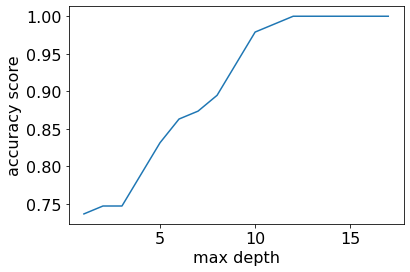

In [7]:
max_depths = np.arange(1, 18)
scores = []
for max_depth in max_depths:
    score = DecisionTreeClassifier(max_depth=max_depth).fit(X_nodup, y_nodup).score(X_nodup, y_nodup)
    scores.append(score)
plt.plot(max_depths, scores);
plt.xlabel("max depth");
plt.ylabel("accuracy score");

- We could also look at the same plot but flip the $y$ axis. 
- Currently it is accuracy, or % correct. But we can also do error, or % incorrect, which is very common:

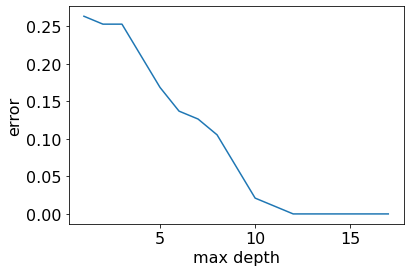

In [30]:
plt.plot(max_depths, 1-np.array(scores))
plt.xlabel("max depth");
plt.ylabel("error");

- Why not just use a very deep decision tree for every supervised learning problem and get super high accuracy?
- Well, the goal of supervised learning is to predict unseen/new data...
  - The above decision tree has 100% accuracy on the training data **where we already know the answer**.
  - It perfectly labels the data we used to make the tree...
  - But we want to know how our model performs on data not used in training.
  - We will split our original dataset into two parts, one for "training" and one for "testing".

In [21]:
df_train, df_test = train_test_split(df_nodup, random_state=123)

Note: `train_test_split` splits randomly. 

- If you just took the top part and the bottom part of your dataframe, you could get terrible results.
- E.g. if they were sorted by one of the columns.
- **Make sure you split randomly** ideally be using a function like `train_test_split`.

Continuing on:

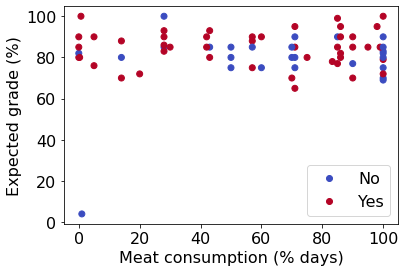

In [22]:
scatter = plt.scatter(df_train["meat"], df_train["grade"], c=df_train["cilantro"]=="Yes", cmap=plt.cm.coolwarm);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");
plt.legend(scatter.legend_elements()[0], ["No", "Yes"]);

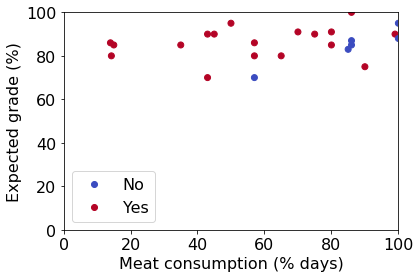

In [23]:
scatter = plt.scatter(df_test["meat"], df_test["grade"], c=df_test["cilantro"]=="Yes", cmap=plt.cm.coolwarm);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");
plt.xlim((0,100));
plt.ylim((0,100));
plt.legend(scatter.legend_elements()[0], ["No", "Yes"]);

This is where we left off last time.

In [38]:
X_train = df_train[["meat", "grade"]]
y_train = df_train["cilantro"]
X_test  = df_test[["meat", "grade"]]
y_test  = df_test["cilantro"]

In [39]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train);

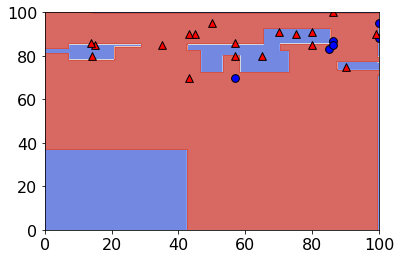

In [40]:
plot_classifier(X_test, y_test, tree, ticks=True, lims=(0,100,0,100));

- The plot above shows the boundaries from the tree trained on **training data**, but the points shown are **test data**.
- In this plot we can see some mistakes.

In [41]:
tree.score(X_train, y_train)

1.0

In [42]:
tree.score(X_test, y_test)

0.5

- Our accuracy on the testing data is lower than on the training data. This phenomenon is called **overfitting**.
- Sometimes overfitting can be totally disastrous. 
- One way to combat this issue is to reduce the max depth!
- We're really just at the tip of the iceberg here - overfitting is a huge problem in machine learning and there are many ways to (try to) deal with it. 

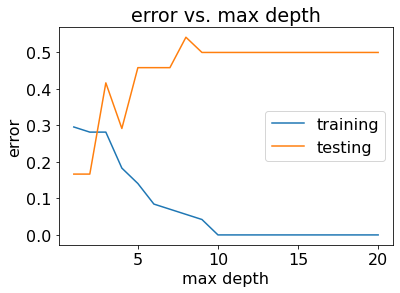

In [43]:
max_depth = []
train_error = []
test_error = []
for depth in np.arange(1, 21):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=1)
    tree.fit(X_train, y_train)  
    max_depth.append(depth)    
    train_error.append(1 - tree.score(X_train, y_train))
    test_error.append(1 - tree.score(X_test, y_test))

plt.plot(max_depth, train_error, label="training");
plt.plot(max_depth, test_error, label="testing");
plt.xlabel("max depth");
plt.ylabel("error");
plt.title("error vs. max depth");
plt.legend();

## Terminology: the 4 data sets (5 min)

- We just talked about "test" data. People also talk about "validation" data.
- There isn't good concensus on the terminology. What is test? What is validation?
- In CPSC 330, validation and test data are cases where we have access to the target values (i.e. we split them off).
  - Validation data is used for model validaiton and hyperparameter tuning; we don't pass these into `fit`.  
  - Test data is used as a final sanity-check.
- I will use "deployment" to refer to data where we do **not** have access to the target values.

So:

- Deployment error is the thing we _really_ care about.
- We use validation/test error as a proxy for deployment error, and we hope they are similar.
- So, if our model does well on the validation/test data, we hope it will do well on deployment data.

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

- Keep in mind we are splitting the data "vertically" with horizontal cuts:

In [44]:
df_train

,meat,grade,cilantro
89,20.0,72,Yes
24,100.0,75,No
82,71.0,65,Yes
9,28.0,85,No
21,14.0,80,No
...,...,...,...
57,43.0,93,Yes
83,57.0,90,Yes
17,100.0,85,No
92,57.0,75,Yes


By the end of class today we'll have a general recipe for a train/validation/test procedure that we'll use throughout the course (and hopefully beyond!).

## Sources of error and the "fundamental trade-off" (25 mins)


We're going to think about 3 types of error:

- $E_\textrm{train}$ is your training error.
- $E_\textrm{test}$ is your test error.
- $E_\textrm{best}$ is the best possible error you could get for a given problem.

Q: why is $E_\textrm{best}>0$ ?

<br><br><br><br>

- Let's think about a dataset with no features. 
- In that case, all you can do is what `DummyClassifier` does. 
- So in this case there's a "best error" since you cannot do better than that with no features. 
- If there are features, we'll be able to do better.
- With this `DummyClassifier` scenario $E_\textrm{best} = E_\textrm{train} = E_\textrm{test}$.

In [46]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train, y_train);
dc.score(X_train, y_train)

0.6338028169014085

In [47]:
dc.score(X_test, y_test)

0.75

- But the scores aren't the same?
- This is where everything gets tricky.
- They will be the same **on average** because both sets are just random samples from the data.
- But they may not be the same in a specific case.
- The more data you have, the closer they will be (law of large numbers).

Next scenario: a dataset with random features.

In [53]:
X_train_random = np.random.rand(len(y_train), 10)
X_test_random = np.random.rand(len(y_test), 10)

Q: what is $E_\textrm{best}$ here?

<br><br><br><br>

A: It's still the same as before, $E_\textrm{best}= E_\textrm{test}$, but $E_\textrm{train}$ **is lower now**.

In [51]:
tree = DecisionTreeClassifier()
tree.fit(X_train_random, y_train);

In [52]:
tree.score(X_train_random, y_train)

1.0

In [54]:
tree.score(X_test_random, y_test)

0.5833333333333334

So here, $E_\textrm{train}<E_\textrm{test}=E_\textrm{best}$.

Next scenario: our cilantro dataset

- In this case, assuming there is any actual relationship between the features and the target, we can start lowering $E_\textrm{best}$.
- The more "signal" (information about the target) is contained in the features, the lower $E_\textrm{best}$ can go.
- But it won't go to zero on a real dataset, because **the target is not a fixed deterministic function of the features** in basically any real case.
  - There is always some "unexplained" part or "random" part.
- To make matters worse, and this is one of the biggest challenges in supervised learning, you never know what $E_\textrm{best}$ actually is.

So here, a typical scenario is $E_\textrm{train}<E_\textrm{test}<E_\textrm{best}$ but this is not always the case. 

3. A dataset with a predictive (but synthetic) feature, for example one feature where feature = target*2 + i.i.d. N(0,1). With this dataset, E_best finally goes down, _but not to zero_ because of the noise. Here we can also demonstrate that E_best is a property of the problem/data and E_train & E_test are a property of the model. From here we can show various scenarions:
    - We can show the case of _achieving_ E_test = E_best with a good model, prediction = feature/2. In this case I'd expect E_test = E_train = E_best > 0. 
    - Or we can have a worse model, prediction = feature, where E_test is better than it was before but not as good as E_best. And then another key point that in a real situation you don't know where E_best is so you don't know if you can still do better with a better model. In this case I'd expect 0 < E_test = E_train < E_best.
    - Or we can have the overfitting scenario, prediction = target for feature values in the training set ("memorization") and prediction = 0 (or some arbitrary prediction scheme) otherwise. In this case 0 = E_train < E_best < E_test. This is a really nuanced and complicated scenario that I think might take 15-20 min to cover in a class. Why is E_train=0? Why is E_train < E_best? Why is E_best < E_test? Now the tradeoff is shining again: we have lowered E_train but raised E_test - E_train (and in this case also raised E_test, but this is not always the case with the fundamental tradeoff! and a common misconception, I think - that the tradeoff means you lower E_train and thus raise E_test). This E_train < E_best < E_test is the overfitting scenario we usually operate in. E_best < E_train < E_test is the underfitting scenario we usually operate in. 
4. The trivial case where feature = target. In this case E_best = E_test = E_train = 0. Not too interesting but worth mentioning maybe.

You can typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

In [34]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1)

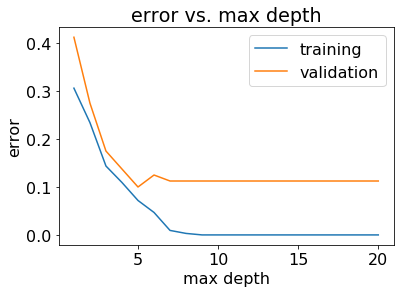

In [35]:
# calculation loop
max_depth = []
train_error = []
valid_error = []
for depth in np.arange(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1).fit(X_train, y_train)  
    max_depth.append(depth)    
    train_error.append(1 - model.score(X_train, y_train))
    valid_error.append(1 - model.score(X_valid, y_valid))

plt.plot(max_depth, train_error, label="training");
plt.plot(max_depth, valid_error, label="validation");
plt.xlabel("max depth");
plt.ylabel("error");
plt.title("error vs. max depth");
plt.legend();

- We see that validation error does not necessarily decrease with training error.
- As we make a more complex model, we are fitting to the peculiarities in our training data.
- These "peculiarities" do not generalize well to new data.
- There is usually a point at which test error levels off or even gets worse!
- (In this case, nothing is changing after depth 9 or so, but this is specific to decision trees)

### "The fundamental trade-off"

$E_{deploy} = E_{train} + E_{approx}$

$E_{approx} = (E_{deploy} - E_{train})$

- There is generally a "trade-off" between complexity and deployment error
- A more complex model (e.g., higher depth tree) will fit closer to the peculiarities of the training data
- i.e., $E_{approx}$ tends to get bigger as our model becomes more complex
- This means it will likely not generalise well to new data!
- $E_{approx}$ tends to get smaller with more data

- **Underfitting**: decision stump, low $E_{approx}$ but might be high $E_{train}$ (not sensitive to training set)
- **Overfitting**: very deep tree, low $E_{train}$ but might be high $E_{approx}$ (highly sensitive to training set)

Note: this fundamental trade-off also called the [bias/variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) in statistics.

### Finding the "optimal model"

- We could pick the model with the lowest validation error.
- This is a reasonable approach for now.
- But it would also be nice to have a model with low approximation error if possible.


### Validation vs. deployment

- A big problem is that we use validation error as a proxy for deployment error, but it might not be.
- We'll have to revisit this issue as we go through the course.

- Even late in the course, some students think that the fundamental tradeoff is between train error and test error, rather than train error and approx error. In particular they thought that making a model more complex lowers the train and approx error (or something). Need to make this more clear and show these sort of pareto diagrams. There was the new type of diagram I had in mind with test vs. train instead of train/test vs. complexity. I think having it on one curve makes it clearer to compare 2 models because now each curve is a model, and you can see a better vs. worse model. 


## True/False (10 min)

1. In supervised learning, the training error is always lower than the validation error.
2. The fundamental tradeoff of ML states that as training error goes down, validation error goes up.
3. More "complicated" models are more likely to overfit than "simple" ones.
4. If we had an infinite amount of training data, overfitting would not be a problem.
5. If our training error is extremely low, that means we're overfitting.

<br><br><br><br><br><br><br><br>

## Break (5 mins)

## Cross-validation (15 mins)

There are several problems with having a single train/validation split:

- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.

#### A solution: $k$-fold cross-validation

The figure below shows 5-fold cross-validation:

<img src='img/cv.png' width="700">

- Helps us use all of our data for training/testing!
- Get a more "robust" measure of error on unseen data.
- Split the data into $k$ folds ($k>2$, often $k=10$).
- Each "fold" gets a turn at being the validation set.
- We then average our $k$ results.

In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
model = DecisionTreeClassifier(max_depth=1)

In [38]:
cv_score = cross_val_score(model, X, y, cv=10)
cv_score

array([0.41463415, 0.41463415, 0.41463415, 0.68292683, 0.825     ,
       0.6       , 0.58974359, 0.58974359, 0.58974359, 0.58974359])

In [39]:
print(f"Average cross-validation score = {np.mean(cv_score):.2f}")

Average cross-validation score = 0.57


Note: these functions do not shuffle? but there may still be randomness in the models themselves. train_test_splits shuffles.

#### Cross-validation for hyperparameter tuning

```
for hyperparameters in (hypers1, hypers2, ...):
    score = cross_val_score(hypers1)
pick hypers with best score
```

Unpack this a bit...

```
for hyperparameters in (hypers1, hypers2, ...):
    for fold in folds:
        get score give fold and hypers
    compute average score
pick hypers with best score
```

In [ ]:
max_depth = []
train_error = []
test_error = []
for depth in np.arange(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1).fit(X_train, y_train)  
    max_depth.append(depth)    
    train_error.append(1 - model.score(X_train, y_train))
    test_error.append(1 - model.score(X_test, y_test))

plt.plot(max_depth, train_error, label="training");
plt.plot(max_depth, test_error, label="testing");
plt.xlabel("max depth");
plt.ylabel("error");
plt.title("error vs. max depth");
plt.legend();

## True/False: cross-validation (10 min)

1. $k$-fold cross validation calls `fit` $k$ times and `predict` $k$ times.
2. The goal of cross-validation is to obtain a better estimate of test error than just using a single validation set.
3. The main disadvantage of using a large $k$ in cross-validation is running time.
4. $2$-fold cross validation is the same thing as using a validation set that's 50% the size of your training set.